<a href="https://colab.research.google.com/github/CarolinaBRangel/ML-Final-Project/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando os dados e pacotes

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
col_list = ['month', 'year', 'sell_price','sales', 'cat_id', 'state_id', 'd', 'wday', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI']

train = pd.read_csv('/content/drive/MyDrive/train.csv', usecols=col_list)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
train = train[['year', 'month', 'wday', 'd', 'sell_price','sales', 'state_id', 'cat_id', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI']]

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: 
        col_type = df[col].dtypes
        if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
          else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(train)

Mem. usage decreased to 1887.51 Mb (55.2% reduction)


# Data Prep I: Variáveis

In [ ]:
train

,year,month,wday,d,sell_price,sales,state_id,cat_id,event_type_1,snap_CA,snap_TX,snap_WI
0,2011,1,1,d_1,0.459961,12,CA,HOBBIES,0,0,0,0
1,2011,1,2,d_2,0.459961,15,CA,HOBBIES,0,0,0,0
2,2011,1,3,d_3,0.459961,0,CA,HOBBIES,0,0,0,0
3,2011,2,4,d_4,0.459961,0,CA,HOBBIES,0,1,1,0
4,2011,2,5,d_5,0.459961,0,CA,HOBBIES,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,2016,4,2,d_1913,3.980469,0,WI,FOODS,0,0,0,0
46027953,2016,4,1,d_1912,1.280273,1,WI,FOODS,0,0,0,0
46027954,2016,4,2,d_1913,1.280273,3,WI,FOODS,0,0,0,0
46027955,2016,4,1,d_1912,1.000000,0,WI,FOODS,0,0,0,0


In [ ]:
train['d'] = train['d'].map(lambda x: x.lstrip('d_'))

In [ ]:
train['d'] = pd.to_numeric(train['d'])

In [ ]:
train = reduce_mem_usage(train)

Mem. usage decreased to 1624.14 Mb (14.0% reduction)


In [ ]:
train['snap'] = train['snap_CA'] + train['snap_TX'] + train['snap_WI']

In [ ]:
train = pd.get_dummies(train, columns = ['event_type_1'])

In [ ]:
train = train.drop('event_type_1_0', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
train

,year,month,wday,d,sell_price,sales,state_id,cat_id,snap_CA,snap_TX,snap_WI,snap,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
0,2011,1,1,1,0.459961,12,CA,HOBBIES,0,0,0,0,0,0,0,0
1,2011,1,2,2,0.459961,15,CA,HOBBIES,0,0,0,0,0,0,0,0
2,2011,1,3,3,0.459961,0,CA,HOBBIES,0,0,0,0,0,0,0,0
3,2011,2,4,4,0.459961,0,CA,HOBBIES,1,1,0,2,0,0,0,0
4,2011,2,5,5,0.459961,0,CA,HOBBIES,1,0,1,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,2016,4,2,1913,3.980469,0,WI,FOODS,0,0,0,0,0,0,0,0
46027953,2016,4,1,1912,1.280273,1,WI,FOODS,0,0,0,0,0,0,0,0
46027954,2016,4,2,1913,1.280273,3,WI,FOODS,0,0,0,0,0,0,0,0
46027955,2016,4,1,1912,1.000000,0,WI,FOODS,0,0,0,0,0,0,0,0


In [ ]:
train['revenue'] = train['sell_price'] * train['sales']

In [ ]:
train = reduce_mem_usage(train)

Mem. usage decreased to 1580.24 Mb (5.3% reduction)


In [ ]:
train['weekend'] = train['wday'] <= 2
train['sextou'] = train['wday'] == 7
train['weekday'] = (train['wday'] <= 6) & (train['wday'] >= 3)

In [ ]:
cols = ['weekend', 'sextou', 'weekday']
train[cols] = train[cols].astype(int)

In [ ]:
train

,year,month,wday,d,sell_price,sales,state_id,cat_id,snap_CA,snap_TX,snap_WI,snap,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,revenue,weekend,sextou,weekday
0,2011,1,1,1,0.459961,12,CA,HOBBIES,0,0,0,0,0,0,0,0,5.519531,1,0,0
1,2011,1,2,2,0.459961,15,CA,HOBBIES,0,0,0,0,0,0,0,0,6.898438,1,0,0
2,2011,1,3,3,0.459961,0,CA,HOBBIES,0,0,0,0,0,0,0,0,0.000000,0,0,1
3,2011,2,4,4,0.459961,0,CA,HOBBIES,1,1,0,2,0,0,0,0,0.000000,0,0,1
4,2011,2,5,5,0.459961,0,CA,HOBBIES,1,0,1,2,0,0,0,0,0.000000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,2016,4,2,1913,3.980469,0,WI,FOODS,0,0,0,0,0,0,0,0,0.000000,1,0,0
46027953,2016,4,1,1912,1.280273,1,WI,FOODS,0,0,0,0,0,0,0,0,1.280273,1,0,0
46027954,2016,4,2,1913,1.280273,3,WI,FOODS,0,0,0,0,0,0,0,0,3.839844,1,0,0
46027955,2016,4,1,1912,1.000000,0,WI,FOODS,0,0,0,0,0,0,0,0,0.000000,1,0,0


# Data Prep II: Agregação 

## Agregação: Vendas totais

In [ ]:
train_total = train.groupby(['d']).agg({
    'sales' : 'sum',
    'revenue' : 'sum',
    'year': 'mean',
    'month': 'mean',
    'wday' : 'mean',
    'weekday': 'mean',
    'sextou': 'mean', 
    'weekend' : 'mean',
    'snap': 'mean', 
    'event_type_1_Cultural' : 'mean', 
    'event_type_1_National': 'mean', 
    'event_type_1_Religious' : 'mean', 
    'event_type_1_Sporting' : 'mean'})

In [ ]:
train_total

,sales,revenue,year,month,wday,weekday,sextou,weekend,snap,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
d,,,,,,,,,,,,,
1,32631.0,inf,2011.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,31749.0,inf,2011.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,23783.0,57696.0,2011.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25412.0,60768.0,2011.0,2.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
5,19146.0,46976.0,2011.0,2.0,5.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,35343.0,inf,2016.0,4.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1910,35033.0,inf,2016.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1911,40517.0,inf,2016.0,4.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_total['avg_price'] = train.groupby('d').apply(lambda x: np.average(x['sell_price'], weights=x['sales']))

In [ ]:
train_total

,sales,revenue,year,month,wday,weekday,sextou,weekend,snap,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,avg_price
d,,,,,,,,,,,,,,
1,32631.0,inf,2011.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.502284
2,31749.0,inf,2011.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.487366
3,23783.0,57696.0,2011.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.426425
4,25412.0,60768.0,2011.0,2.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.391074
5,19146.0,46976.0,2011.0,2.0,5.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.452781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,35343.0,inf,2016.0,4.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.192420
1910,35033.0,inf,2016.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.151647
1911,40517.0,inf,2016.0,4.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.135520


<Figure size 1080x540 with 0 Axes>

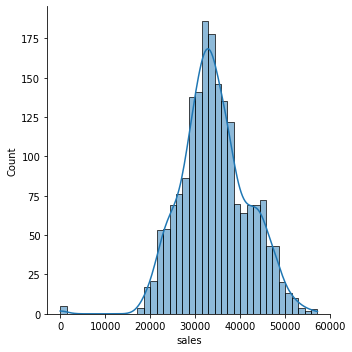

In [ ]:
plt.figure(figsize=(15, 7.5))
sns.displot(train_total['sales'], kde=True);

<Figure size 1080x540 with 0 Axes>

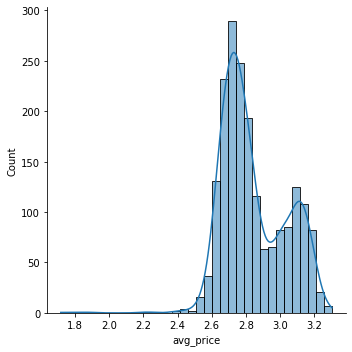

In [ ]:
plt.figure(figsize=(15, 7.5))
sns.displot(train_total['avg_price'], kde=True);

In [ ]:
fig = px.bar(
    train_total.groupby(['year']).mean().reset_index(), 
    x="year", 
    y="sales",
    title="Average Sales per Year"
)
fig.show()

In [ ]:
fig = px.bar(
    train_total.groupby(['month']).mean().reset_index(), 
    x="month", 
    y="sales",
    title="Average Sales per Month"
)
fig.show()

In [ ]:
fig = px.bar(
    train_total.groupby(['snap']).mean().reset_index(), 
    x="snap", 
    y="sales",
    title="Average Sales per Snap Count"
)
fig.show()

## Aregação: Total por estado

In [ ]:
train_state = train.groupby(['state_id', 'd']).agg({
    'sales' : 'sum',
    'revenue' :'sum',
    'year': 'mean',
    'month': 'mean',
    'wday': 'mean',
    'weekday': 'mean',
    'sextou': 'mean', 
    'weekend' : 'mean',
    'event_type_1_Cultural' : 'mean', 
    'event_type_1_National': 'mean', 
    'event_type_1_Religious' : 'mean', 
    'event_type_1_Sporting' : 'mean',
    'snap_CA': 'mean',
    'snap_WI': 'mean',
    'snap_TX': 'mean'})

In [ ]:
train_state

sales  revenue    year  month  wday  weekday  sextou  weekend  \
state_id d                                                                     
CA       1     14195  36288.0  2011.0    1.0   1.0      0.0     0.0      1.0   
         2     13805  35040.0  2011.0    1.0   2.0      0.0     0.0      1.0   
         3     10108  25280.0  2011.0    1.0   3.0      1.0     0.0      0.0   
         4     11047  26912.0  2011.0    2.0   4.0      1.0     0.0      0.0   
         5      9925  25184.0  2011.0    2.0   5.0      1.0     0.0      0.0   
...              ...      ...     ...    ...   ...      ...     ...      ...   
WI       1909  10595  31504.0  2016.0    4.0   5.0      1.0     0.0      0.0   
         1910  10943  32368.0  2016.0    4.0   6.0      1.0     0.0      0.0   
         1911  12807  37504.0  2016.0    4.0   7.0      0.0     1.0      0.0   
         1912  14862  43200.0  2016.0    4.0   1.0      0.0     0.0      1.0   
         1913  14326  42816.0  2016.0    4.0   2.0      0.0     0.0      1.0   

               event_type_1_Cultural  event_type_1_National  \
state_id d                                                    
CA       1                       0.0                    0.0   
         2                       0.0                    0.0   
         3                       0.0                    0.0   
         4                       0.0                    0.0   
         5                       0.0                    0.0   
...                              ...                    ...   
WI       1909                    0.0                    0.0   
         1910                    0.0                    0.0   
         1911                    0.0                    0.0   
         1912                    0.0                    0.0   
         1913                    0.0                    0.0   

               event_type_1_Religious  event_type_1_Sporting  snap_CA  \
state_id d                                                              
CA       1                        0.0                    0.0      0.0   
         2                        0.0                    0.0      0.0   
         3                        0.0                    0.0      0.0   
         4                        0.0                    0.0      1.0   
         5                        0.0                    0.0      1.0   
...                               ...                    ...      ...   
WI       1909                     0.0                    0.0      0.0   
         1910                     0.0                    0.0      0.0   
         1911                     0.0                    0.0      0.0   
         1912                     0.0                    0.0      0.0   
         1913                     0.0                    0.0      0.0   

               snap_WI  snap_TX  
state_id d                       
CA       1         0.0      0.0  
         2         0.0      0.0  
         3         0.0      0.0  
         4         0.0      1.0  
         5         1.0      0.0  
...                ...      ...  
WI       1909      0.0      0.0  
         1910      0.0      0.0  
         1911      0.0      0.0  
         1912      0.0      0.0  
         1913      0.0      0.0  

[5739 rows x 15 columns]

In [ ]:
train_state['avg_price'] = train.groupby(['state_id', 'd']).apply(lambda x: np.average(x['sell_price'], weights=x['sales']))

In [ ]:
train_state

sales  revenue    year  month  wday  weekday  sextou  weekend  \
state_id d                                                                     
CA       1     14195  36288.0  2011.0    1.0   1.0      0.0     0.0      1.0   
         2     13805  35040.0  2011.0    1.0   2.0      0.0     0.0      1.0   
         3     10108  25280.0  2011.0    1.0   3.0      1.0     0.0      0.0   
         4     11047  26912.0  2011.0    2.0   4.0      1.0     0.0      0.0   
         5      9925  25184.0  2011.0    2.0   5.0      1.0     0.0      0.0   
...              ...      ...     ...    ...   ...      ...     ...      ...   
WI       1909  10595  31504.0  2016.0    4.0   5.0      1.0     0.0      0.0   
         1910  10943  32368.0  2016.0    4.0   6.0      1.0     0.0      0.0   
         1911  12807  37504.0  2016.0    4.0   7.0      0.0     1.0      0.0   
         1912  14862  43200.0  2016.0    4.0   1.0      0.0     0.0      1.0   
         1913  14326  42816.0  2016.0    4.0   2.0      0.0     0.0      1.0   

               event_type_1_Cultural  event_type_1_National  \
state_id d                                                    
CA       1                       0.0                    0.0   
         2                       0.0                    0.0   
         3                       0.0                    0.0   
         4                       0.0                    0.0   
         5                       0.0                    0.0   
...                              ...                    ...   
WI       1909                    0.0                    0.0   
         1910                    0.0                    0.0   
         1911                    0.0                    0.0   
         1912                    0.0                    0.0   
         1913                    0.0                    0.0   

               event_type_1_Religious  event_type_1_Sporting  snap_CA  \
state_id d                                                              
CA       1                        0.0                    0.0      0.0   
         2                        0.0                    0.0      0.0   
         3                        0.0                    0.0      0.0   
         4                        0.0                    0.0      1.0   
         5                        0.0                    0.0      1.0   
...                               ...                    ...      ...   
WI       1909                     0.0                    0.0      0.0   
         1910                     0.0                    0.0      0.0   
         1911                     0.0                    0.0      0.0   
         1912                     0.0                    0.0      0.0   
         1913                     0.0                    0.0      0.0   

               snap_WI  snap_TX  avg_price  
state_id d                                  
CA       1         0.0      0.0   2.555590  
         2         0.0      0.0   2.538772  
         3         0.0      0.0   2.501373  
         4         0.0      1.0   2.436608  
         5         1.0      0.0   2.536634  
...                ...      ...        ...  
WI       1909      0.0      0.0   2.973461  
         1910      0.0      0.0   2.958158  
         1911      0.0      0.0   2.928453  
         1912      0.0      0.0   2.907736  
         1913      0.0      0.0   2.988914  

[5739 rows x 16 columns]

<Figure size 1080x540 with 0 Axes>

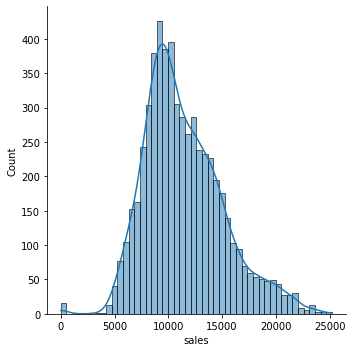

In [ ]:
plt.figure(figsize=(15, 7.5))
sns.displot(train_state['sales'], kde=True);

<Figure size 1080x540 with 0 Axes>

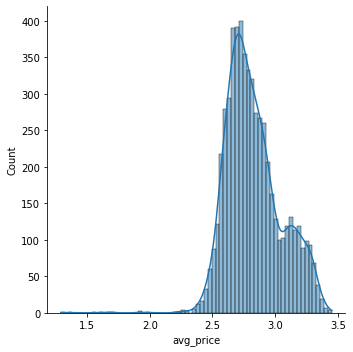

In [ ]:
plt.figure(figsize=(15, 7.5))
sns.displot(train_state['avg_price'], kde=True);

In [ ]:
fig = px.bar(
    train_state.groupby(['state_id']).mean().reset_index(), 
    x="state_id", 
    y="sales",
    title="Average Sales per State"
)
fig.show()

## Agregação: Total por Categoria

In [ ]:
train_cat = train.groupby(['cat_id', 'd']).agg({
    'sales' : 'sum',
    'revenue' : 'sum',
    'year': 'mean',
    'month': 'mean',
    'wday': 'mean',
    'weekday': 'mean',
    'sextou': 'mean', 
    'weekend' : 'mean',
    'event_type_1_Cultural' : 'mean', 
    'event_type_1_National': 'mean', 
    'event_type_1_Religious' : 'mean', 
    'event_type_1_Sporting' : 'mean',
    'snap': 'mean',
    'd': 'mean'})

In [ ]:
train_cat['d'] = train_cat['d'].astype(int)

In [ ]:
train_cat

sales  revenue    year  month  wday  weekday  sextou  \
cat_id    d                                                              
FOODS     1     23178.0  48064.0  2011.0    1.0   1.0      0.0     0.0   
          2     22758.0  46464.0  2011.0    1.0   2.0      0.0     0.0   
          3     17174.0  34944.0  2011.0    1.0   3.0      1.0     0.0   
          4     18878.0  38400.0  2011.0    2.0   4.0      1.0     0.0   
          5     14603.0  30560.0  2011.0    2.0   5.0      1.0     0.0   
...                 ...      ...     ...    ...   ...      ...     ...   
HOUSEHOLD 1909   8239.0  33376.0  2016.0    4.0   5.0      1.0     0.0   
          1910   8363.0  32960.0  2016.0    4.0   6.0      1.0     0.0   
          1911   9728.0  39328.0  2016.0    4.0   7.0      0.0     1.0   
          1912  12248.0  50176.0  2016.0    4.0   1.0      0.0     0.0   
          1913  12458.0  53024.0  2016.0    4.0   2.0      0.0     0.0   

                weekend  event_type_1_Cultural  event_type_1_National  \
cat_id    d                                                             
FOODS     1         1.0                    0.0                    0.0   
          2         1.0                    0.0                    0.0   
          3         0.0                    0.0                    0.0   
          4         0.0                    0.0                    0.0   
          5         0.0                    0.0                    0.0   
...                 ...                    ...                    ...   
HOUSEHOLD 1909      0.0                    0.0                    0.0   
          1910      0.0                    0.0                    0.0   
          1911      0.0                    0.0                    0.0   
          1912      1.0                    0.0                    0.0   
          1913      1.0                    0.0                    0.0   

                event_type_1_Religious  event_type_1_Sporting  snap     d  
cat_id    d                                                                
FOODS     1                        0.0                    0.0   0.0     1  
          2                        0.0                    0.0   0.0     2  
          3                        0.0                    0.0   0.0     3  
          4                        0.0                    0.0   2.0     4  
          5                        0.0                    0.0   2.0     5  
...                                ...                    ...   ...   ...  
HOUSEHOLD 1909                     0.0                    0.0   0.0  1909  
          1910                     0.0                    0.0   0.0  1910  
          1911                     0.0                    0.0   0.0  1911  
          1912                     0.0                    0.0   0.0  1912  
          1913                     0.0                    0.0   0.0  1913  

[5739 rows x 14 columns]

In [ ]:
#n sei se isso funciona
# Define a lambda function to compute the weighted mean:
#wm = lambda x: np.average(x, weights=df.loc[x.index, "adjusted_lots"])

# Define a dictionary with the functions to apply for a given column:
# the following is deprecated since pandas 0.20:
# f = {'adjusted_lots': ['sum'], 'price': {'weighted_mean' : wm} }
# df.groupby(["contract", "month", "year", "buys"]).agg(f)

# Groupby and aggregate with namedAgg [1]:
#train_cat.groupby(["cat_id", "d"]).agg(adjusted_lots=("adjusted_lots", "sum"),  
#                                                      price_weighted_mean=("price", wm))

In [ ]:
train_cat[train_cat['sales'] == 0]

sales  revenue    year  month  wday  weekday  sextou  weekend  \
cat_id    d                                                                     
HOBBIES   331     0.0      0.0  2011.0   12.0   2.0      0.0     0.0      1.0   
          697     0.0      0.0  2012.0   12.0   4.0      1.0     0.0      0.0   
          1062    0.0      0.0  2013.0   12.0   5.0      1.0     0.0      0.0   
          1427    0.0      0.0  2014.0   12.0   6.0      1.0     0.0      0.0   
          1792    0.0      0.0  2015.0   12.0   7.0      0.0     1.0      0.0   
HOUSEHOLD 331     0.0      0.0  2011.0   12.0   2.0      0.0     0.0      1.0   
          697     0.0      0.0  2012.0   12.0   4.0      1.0     0.0      0.0   
          1062    0.0      0.0  2013.0   12.0   5.0      1.0     0.0      0.0   
          1427    0.0      0.0  2014.0   12.0   6.0      1.0     0.0      0.0   

                event_type_1_Cultural  event_type_1_National  \
cat_id    d                                                    
HOBBIES   331                     0.0                    1.0   
          697                     0.0                    1.0   
          1062                    0.0                    1.0   
          1427                    0.0                    1.0   
          1792                    0.0                    1.0   
HOUSEHOLD 331                     0.0                    1.0   
          697                     0.0                    1.0   
          1062                    0.0                    1.0   
          1427                    0.0                    1.0   

                event_type_1_Religious  event_type_1_Sporting  snap     d  
cat_id    d                                                                
HOBBIES   331                      0.0                    0.0   0.0   331  
          697                      0.0                    0.0   0.0   697  
          1062                     0.0                    0.0   0.0  1062  
          1427                     0.0                    0.0   0.0  1427  
          1792                     0.0                    0.0   0.0  1792  
HOUSEHOLD 331                      0.0                    0.0   0.0   331  
          697                      0.0                    0.0   0.0   697  
          1062                     0.0                    0.0   0.0  1062  
          1427                     0.0                    0.0   0.0  1427

In [ ]:
for i in train_cat['d']:
  if train_cat['cat_id'] == "HOBBIES" & train_cat['d'] == 331 | train_cat['d'] == 697 | train_cat['d'] == 1062 | train_cat['d'] == 1427 | train_cat['d']== 1792 | train_cat['cat_id'] == "HOUSEHOLD" & train_cat['d'] == 331 | train_cat['d'] == 697 | train_cat['d'] == 1062 | train_cat['d'] == 1427:
    train_cat['avg_price'] = 0
  else:
    train_cat['avg_price'] = train.groupby(['cat_id', 'd']).apply(lambda x: np.average(x['sell_price'], weights=x['sales']))

#eliminar os dias

KeyError: ignored

In [ ]:
train_cat

sales  revenue    year  month  wday  weekday  sextou  \
cat_id    d                                                              
FOODS     1     23178.0  48064.0  2011.0    1.0   1.0      0.0     0.0   
          2     22758.0  46464.0  2011.0    1.0   2.0      0.0     0.0   
          3     17174.0  34944.0  2011.0    1.0   3.0      1.0     0.0   
          4     18878.0  38400.0  2011.0    2.0   4.0      1.0     0.0   
          5     14603.0  30560.0  2011.0    2.0   5.0      1.0     0.0   
...                 ...      ...     ...    ...   ...      ...     ...   
HOUSEHOLD 1909   8239.0  33376.0  2016.0    4.0   5.0      1.0     0.0   
          1910   8363.0  32960.0  2016.0    4.0   6.0      1.0     0.0   
          1911   9728.0  39328.0  2016.0    4.0   7.0      0.0     1.0   
          1912  12248.0  50176.0  2016.0    4.0   1.0      0.0     0.0   
          1913  12458.0  53024.0  2016.0    4.0   2.0      0.0     0.0   

                weekend  event_type_1_Cultural  event_type_1_National  \
cat_id    d                                                             
FOODS     1         1.0                    0.0                    0.0   
          2         1.0                    0.0                    0.0   
          3         0.0                    0.0                    0.0   
          4         0.0                    0.0                    0.0   
          5         0.0                    0.0                    0.0   
...                 ...                    ...                    ...   
HOUSEHOLD 1909      0.0                    0.0                    0.0   
          1910      0.0                    0.0                    0.0   
          1911      0.0                    0.0                    0.0   
          1912      1.0                    0.0                    0.0   
          1913      1.0                    0.0                    0.0   

                event_type_1_Religious  event_type_1_Sporting  snap     d  
cat_id    d                                                                
FOODS     1                        0.0                    0.0   0.0     1  
          2                        0.0                    0.0   0.0     2  
          3                        0.0                    0.0   0.0     3  
          4                        0.0                    0.0   2.0     4  
          5                        0.0                    0.0   2.0     5  
...                                ...                    ...   ...   ...  
HOUSEHOLD 1909                     0.0                    0.0   0.0  1909  
          1910                     0.0                    0.0   0.0  1910  
          1911                     0.0                    0.0   0.0  1911  
          1912                     0.0                    0.0   0.0  1912  
          1913                     0.0                    0.0   0.0  1913  

[5739 rows x 14 columns]

# Train - test split 

In [ ]:
# primeiro irei importar os pacotes necessários para a etapa de constrção de modelos 

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, ElasticNetCV 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
train_t, test_t = train_test_split(train_total, test_size = 0.3, random_state = 2)

In [ ]:
train_s, test_s = train_test_split(train_state, test_size = 0.3, random_state = 2)

In [ ]:
train_c, test_c = train_test_split(train_cat, test_size = 0.3, random_state = 2)

# Outliers

In [ ]:
n = 2

upper_limit = train_t['sales'].mean() + n*train_t['sales'].std()
lower_limit = train_t['sales'].mean() - n*train_t['sales'].std()

print("Highest allowed", upper_limit)
print("Lowest allowed", lower_limit)

Highest allowed 48677.16716526171
Lowest allowed 19842.09347700865


In [ ]:
train_t_trimmed = train_t[
    ( train_t['sales'] < upper_limit ) & 

    ( train_t['sales'] > lower_limit )
    ]

In [ ]:
train_t_censored = pd.DataFrame()

train_t_censored['sales'] =  np.where(
    train_t['sales'] > upper_limit,
        upper_limit,
        np.where(
            train_t['sales'] < lower_limit, # Condition
            lower_limit,                   # Assign If TRUE
            train_t['sales']                # Assign If FALSE
            )
        )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



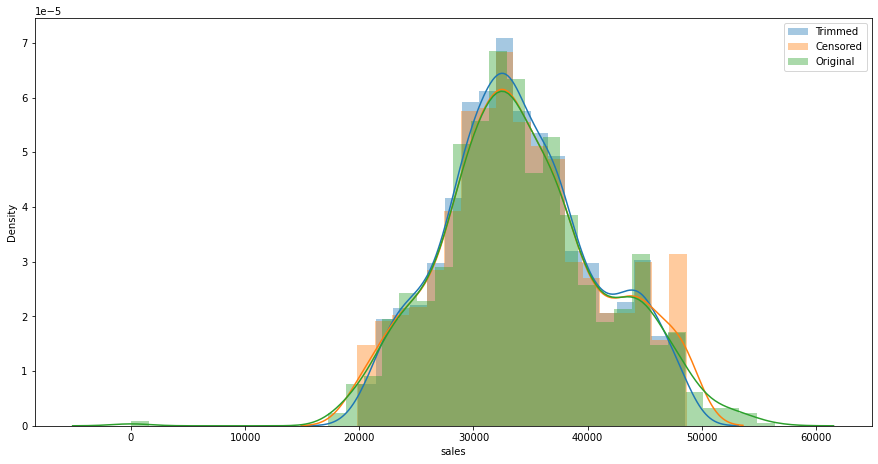

In [ ]:
plt.figure(figsize=(15, 7.5))
sns.distplot(train_t_trimmed['sales'], kde = True, label='Trimmed');
sns.distplot(train_t_censored['sales'], kde = True, label='Censored');
sns.distplot(train_t['sales'], kde = True, label='Original')

plt.legend(loc='upper right')
plt.show()

In [ ]:
upper_limit = train_s['sales'].mean() + n*train_s['sales'].std()
lower_limit = train_s['sales'].mean() - n*train_s['sales'].std()

print("Highest allowed", upper_limit)
print("Lowest allowed", lower_limit)

Highest allowed 18674.672762674505
Lowest allowed 4211.830100158455


In [ ]:
train_s_trimmed = train_s[
    ( train_s['sales'] < upper_limit ) & 

    ( train_s['sales'] > lower_limit )
    ]

In [ ]:
train_s_censored = pd.DataFrame()

train_s_censored['sales'] =  np.where(
    train_s['sales'] > upper_limit,
        upper_limit,
        np.where(
            train_s['sales'] < lower_limit, # Condition
            lower_limit,                   # Assign If TRUE
            train_s['sales']                # Assign If FALSE
            )
        )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



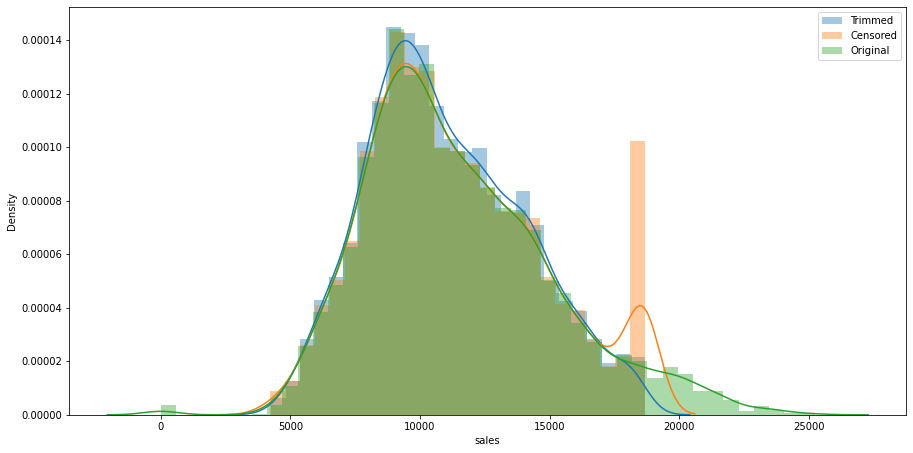

In [ ]:
plt.figure(figsize=(15, 7.5))
sns.distplot(train_s_trimmed['sales'], kde = True, label='Trimmed');
sns.distplot(train_s_censored['sales'], kde = True, label='Censored');
sns.distplot(train_s['sales'], kde = True, label='Original')

plt.legend(loc='upper right')
plt.show()

In [ ]:
upper_limit = train_c['sales'].mean() + n*train_c['sales'].std()
lower_limit = train_c['sales'].mean() - n*train_c['sales'].std()

print("Highest allowed", upper_limit)
print("Lowest allowed", lower_limit)

Highest allowed 29941.06379145597
Lowest allowed -7089.2574683292605


In [ ]:
train_c_trimmed = train_c[
    ( train_c['sales'] < upper_limit ) & 

    ( train_c['sales'] > lower_limit )
    ]

In [ ]:
train_c_censored = pd.DataFrame()

train_c_censored['sales'] =  np.where(
    train_c['sales'] > upper_limit,
        upper_limit,
        np.where(
            train_c['sales'] < lower_limit, # Condition
            lower_limit,                   # Assign If TRUE
            train_c['sales']                # Assign If FALSE
            )
        )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



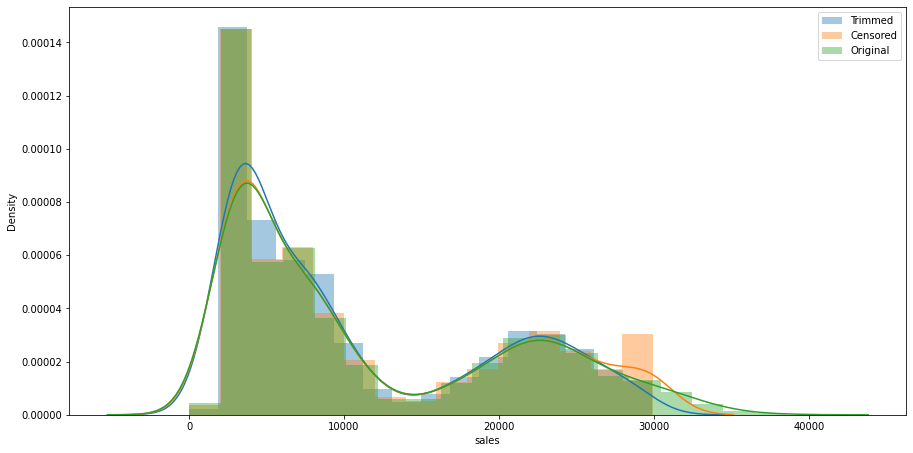

In [ ]:
plt.figure(figsize=(15, 7.5))
sns.distplot(train_c_trimmed['sales'], kde = True, label='Trimmed');
sns.distplot(train_c_censored['sales'], kde = True, label='Censored');
sns.distplot(train_c['sales'], kde = True, label='Original')

plt.legend(loc='upper right')
plt.show()

In [ ]:
train_s = train_s_trimmed
train_t = train_t_trimmed
train_c = train_c_trimmed

# Modelos:

padronizar var dep

In [ ]:
#Aqui vamos definir as medidas de acrutácia
def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs(Y_actual - Y_Predicted)/Y_actual)*100
    return mape

def rmse(Y_actual, Y_Predicted):
    rmse = np.mean((Y_actual - Y_Predicted)**2 /Y_actual )*100
    return rmse   

def mpe(Y_actual, Y_Predicted):
    mpe = np.mean((Y_actual - Y_Predicted)/Y_actual)*100
    return mpe

###Total

In [ ]:
X_train = train_t.drop('sales', 1)
X_test = test_t.drop('sales', 1)
y_train = train_t['sales']
y_test = test_t['sales']

# tirar o preço do Y, média do nível de agregação 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
# Modelo Naive
naive_model = y_train.mean()
pred_naive = np.repeat(naive_model, len(y_test))
print('Mape:', round(mape(y_test, (pred_naive)), 2))
print('Rmse:', round(rmse(y_test, (pred_naive)), 2))
print('Mpe:', round(mpe(y_test, (pred_naive)), 2))

Mape: 1276.45
Rmse: 43020669.78
Mpe: -1261.88


In [ ]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train [[ 'avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)
pred_linear = linear_reg.predict(X_test[['avg_price','weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

print('Mape:', round(mape(y_test, (pred_linear)), 2))
print('Rmse:', round(rmse(y_test, (pred_linear)), 2))
print('Mpe:', round(mpe(y_test, (pred_linear)), 2))

Mape: 913.18
Rmse: 22284460.92
Mpe: -903.28


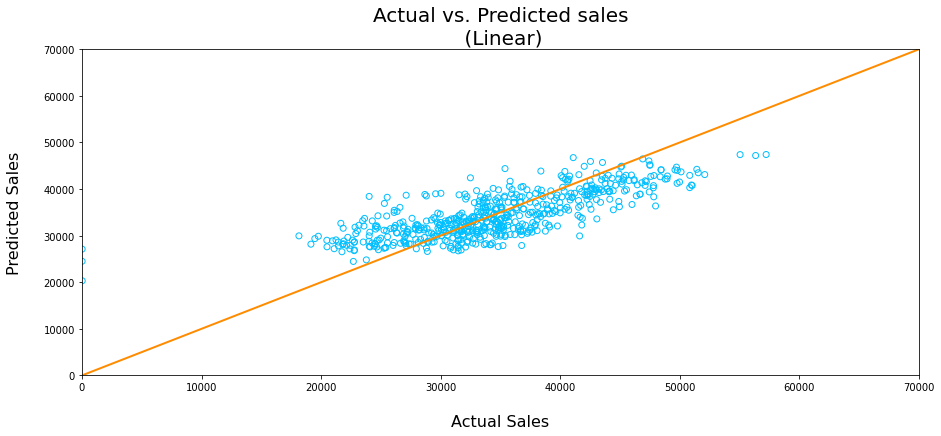

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Linear)", fontsize=20)
plt.scatter(y_test, pred_linear,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0, 70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
linear_reg = sm.OLS(y_train, X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']] )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])
print(linear_reg_fit.summary())

print('Mape:', round(mape(y_test, (linear_reg_pred)), 2))
print('Rmse:', round(rmse(y_test, (linear_reg_pred)), 2))
print('Mpe:', round(mpe(y_test, (linear_reg_pred)), 2))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     184.1
Date:                Tue, 31 May 2022   Prob (F-statistic):          9.87e-207
Time:                        21:01:41   Log-Likelihood:                -12647.
No. Observations:                1289   AIC:                         2.531e+04
Df Residuals:                    1280   BIC:                         2.536e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
avg_price                1.1

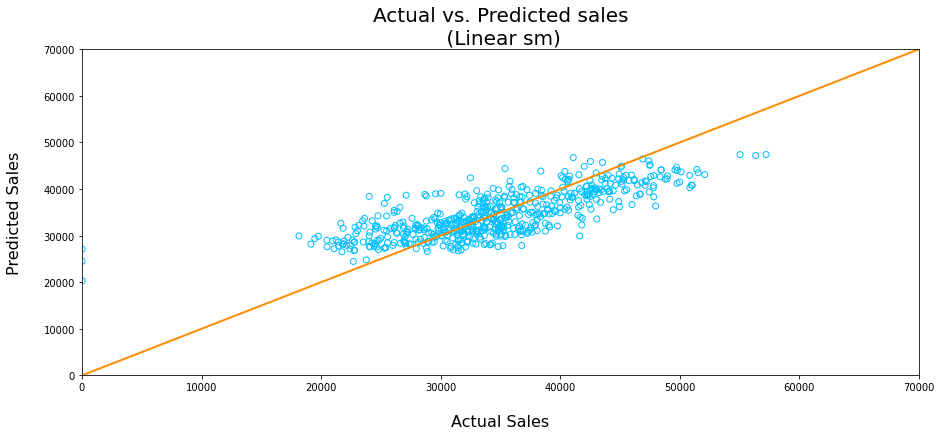

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Linear sm)", fontsize=20)
plt.scatter(y_test, linear_reg_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0, 70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
X_lr = sm.add_constant( X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']] )

X_lr_test = sm.add_constant( X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']] )
linear_reg = sm.OLS(y_train, X_lr )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_lr_test)
print(linear_reg_fit.summary())

print('Mape:', round(mape(y_test, (linear_reg_pred)), 2))
print('Rmse:', round(rmse(y_test, (linear_reg_pred)), 2))
print('Mpe:', round(mpe(y_test, (linear_reg_pred)), 2))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     184.1
Date:                Tue, 31 May 2022   Prob (F-statistic):          9.87e-207
Time:                        21:01:41   Log-Likelihood:                -12647.
No. Observations:                1289   AIC:                         2.531e+04
Df Residuals:                    1280   BIC:                         2.536e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    226

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



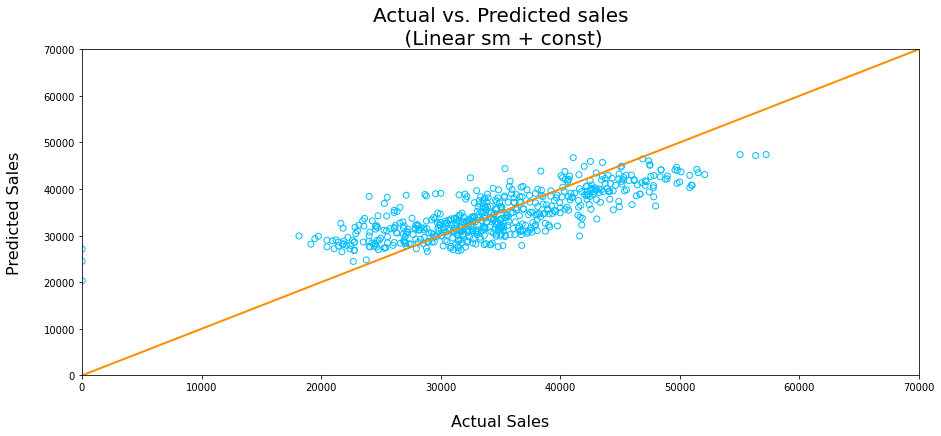

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Linear sm + const)", fontsize=20)
plt.scatter(y_test, linear_reg_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Ridge

alphas = [0.01, 0.02, 0.03, 0.04, 0.05,
          0.1, 0.2, 0.3, 0.4, 0.5,
          0.75, 1, 2,  3, 4, 5, 
          10, 15, 30]

coefs = []
mapes = []
for a in alphas:

   
    ridge_reg =  Ridge(alpha = a)
    ridge_reg.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)
    ridge_pred = ridge_reg.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])


    mapes .append(mape( y_test, (ridge_pred)))   
    coefs.append(ridge_reg.coef_)

coef_ridge = pd.DataFrame(coefs, columns= X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns)
coef_ridge.insert(0, 'Alpha', alphas)
coeg_ridge_melted = coef_ridge.melt(id_vars = 'Alpha')

cv_ridge = pd.DataFrame({ 
    'Alpha': alphas,
    'MAPE': mapes
} )

In [ ]:
cv_ridge

,Alpha,MAPE
0,0.01,913.236961
1,0.02,913.295062
2,0.03,913.353135
3,0.04,913.411182
4,0.05,913.469201
5,0.10,913.758892
6,0.20,914.336251
7,0.30,914.910930
8,0.40,915.483063
9,0.50,916.052566


In [ ]:
px.line(coeg_ridge_melted, x='Alpha', y='value', color = 'variable' )

In [ ]:
ridge_reg = Ridge(alpha = 0.01)
ridge_reg.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)
ridge_pred = ridge_reg.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

print('Mape:', round(mape(y_test, (ridge_pred)), 2))
print('Rmse:', round(rmse(y_test, (ridge_pred)), 2))
print('Mpe:', round(mpe(y_test, (ridge_pred)), 2))

Mape: 913.24
Rmse: 22287224.67
Mpe: -903.34


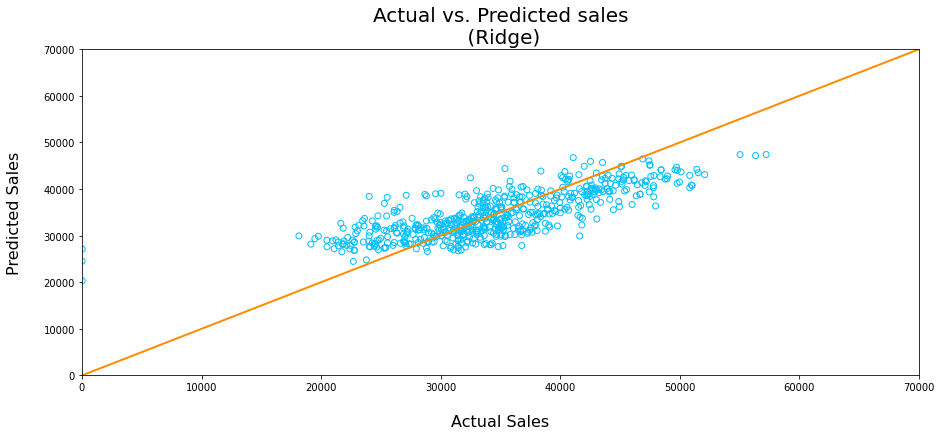

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Ridge)", fontsize=20)
plt.scatter(y_test, ridge_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Lasso

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

lasso_pred = model_lasso.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

coef = pd.Series(model_lasso.coef_, index = X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 8 variables and eliminated the other 1 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

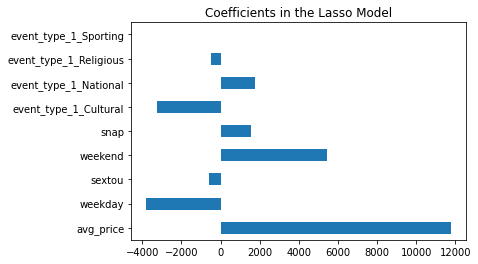

In [ ]:
coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [ ]:
print('Mape:', round(mape(y_test, (lasso_pred)), 2))
print('Rmse:', round(rmse(y_test, (lasso_pred)), 2))
print('Mpe:', round(mpe(y_test, (lasso_pred)), 2))

Mape: 912.65
Rmse: 22258327.22
Mpe: -902.75


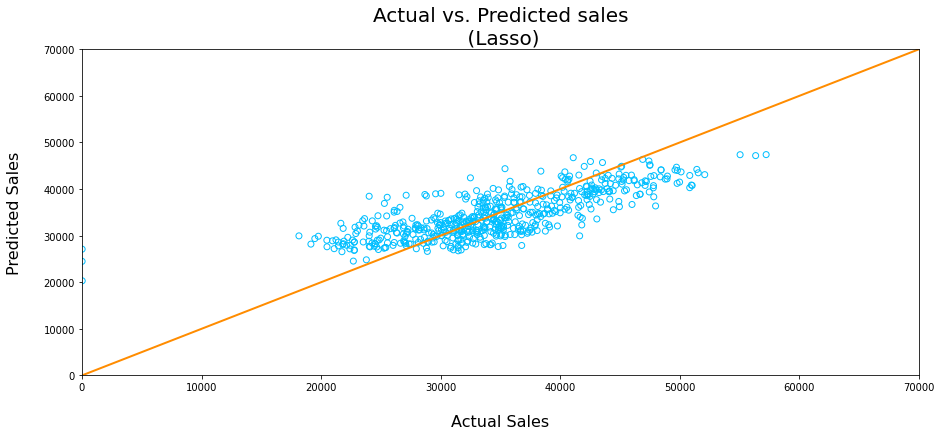

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Lasso)", fontsize=20)
plt.scatter(y_test, lasso_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Elastic Net

model_ElasticNet = ElasticNetCV(
    l1_ratio = [.1, .5, .7, .9, .95, .99, 1],
    n_alphas = 100,
    fit_intercept = True
).fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

elastic_pred = model_ElasticNet.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

In [ ]:
coef = pd.Series(model_ElasticNet.coef_, index = X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 7 variables and eliminated the other 2 variables


Text(0.5, 1.0, 'Coefficients in the ElasticNet Model')

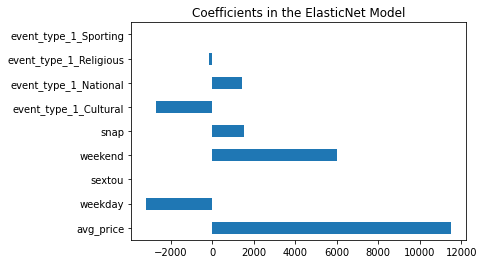

In [ ]:
coef.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")

In [ ]:
print('Mape:', round(mape(y_test, (elastic_pred)), 2))
print('Rmse:', round(rmse(y_test, (elastic_pred)), 2))
print('Mpe:', round(mpe(y_test, (elastic_pred)), 2))

Mape: 907.31
Rmse: 21992077.54
Mpe: -897.44


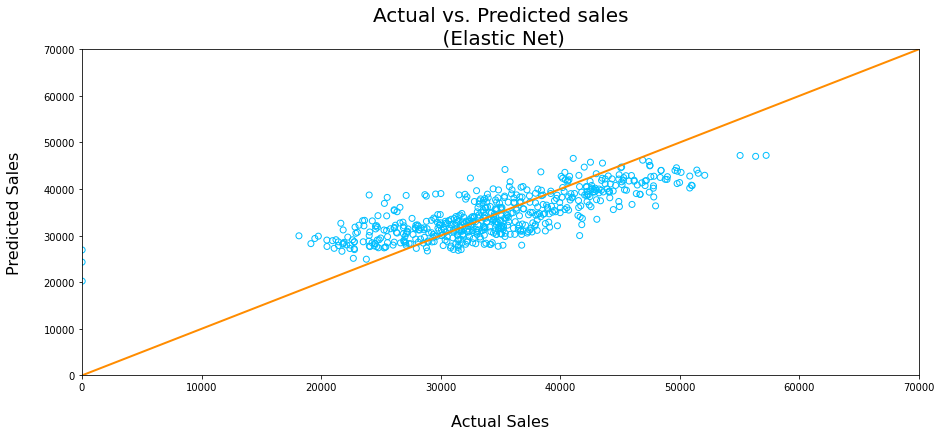

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Elastic Net)", fontsize=20)
plt.scatter(y_test, elastic_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Decision Tree

def find_best_rule(X, y, verbo = False):
    
    best_feature, best_threshold, min_RSS = None, None, np.inf
    
    for feature in X.columns:
       #--------------------------------------------------------- #
       #  This is the "compute_RSS_by_threshold"                  #
       #----------------------------------------------------------#                                                          
        
        thresholds = X[feature].unique().tolist()           #
        thresholds.sort()                                         #
        thresholds = thresholds[1:]                               #
                                                                  #  
        for t in thresholds:                                      #
            x_index = X[feature] < t                        #
            y_left, y_right = y[x_index], y[~x_index] #
            t_RSS = RSS(y_left, y_right)                          #
        #-------------------------------------------------------- #
        
        # If you wanna gain some intuition, set verbo = True
            if verbo == True:
                print('---')
                print("Feature: ", feature)
                print("Threshold: ",t)
                print("Feature-Threshold RSS: ", t_RSS)
                print("Current minimum RSS: ", min_RSS)

        # Save the best_feature and best_threshold!        
            if t_RSS < min_RSS:
                
                min_RSS = t_RSS
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold}

In [ ]:
def squared_residual_sum(y):
    return np.sum((y - np.mean(y)) ** 2)
    
def RSS(y_left, y_right):
    return np.round(squared_residual_sum(y_left) + squared_residual_sum(y_right), 2)

In [ ]:
def DecisionTreeRegressor(X, y, depth, max_depth):
    
    print("Depth"); print(depth)

    # Stop criterias:
    if depth == max_depth or len(X) < 2:   
        print('Stop Criteria Satisfied! Reached terminal node')
        print('Prediction =', np.mean(y))
        # If we are in a leaf node, return its prediction   
        return {'prediction': np.mean(y)}     
    
    rule = find_best_rule(X, y)
    
    print("Rule")
    print(rule)  

    left_ix = X[rule['feature']] < rule['threshold']

    # Here is where the recursion kick-in (so beautiful)
    print('left <-------------')
    rule['left'] = DecisionTreeRegressor( X[left_ix], y[left_ix], 
                                          depth + 1, max_depth )
    
    print(' -------------> right ')
    rule['right'] = DecisionTreeRegressor( X[~left_ix], y[~left_ix],
                                           depth + 1, max_depth)
    
    return rule  

In [ ]:
tree = DecisionTreeRegressor(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train, 0, 3)

Depth
0
Rule
{'feature': 'weekend', 'threshold': 1.0}
left <-------------
Depth
1
Rule
{'feature': 'avg_price', 'threshold': 2.9204862117767334}
left <-------------
Depth
2
Rule
{'feature': 'snap', 'threshold': 1.0}
left <-------------
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 28856.021212121213
 -------------> right 
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 32013.24925816024
 -------------> right 
Depth
2
Rule
{'feature': 'snap', 'threshold': 1.0}
left <-------------
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 33456.626760563384
 -------------> right 
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 36530.94326241135
 -------------> right 
Depth
1
Rule
{'feature': 'avg_price', 'threshold': 2.8632330894470215}
left <-------------
Depth
2
Rule
{'feature': 'snap', 'threshold': 1.0}
left <-------------
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 37376.83185840708
 ------

In [ ]:
from sklearn import tree as sk_tree
from sklearn.metrics import median_absolute_error, mean_absolute_error, r2_score, explained_variance_score

In [ ]:
dtr = sk_tree.DecisionTreeRegressor(max_depth = 3).fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']],y_train)


In [ ]:
import graphviz
dtr_noprune = sk_tree.DecisionTreeRegressor().fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']],y_train)

dot_data = sk_tree.export_graphviz(dtr_noprune, out_file=None, 
                     filled=True, rounded=True,
                     feature_names = X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns) 

In [ ]:
pred_dtr = dtr.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])
pred_dtr_noprune = dtr_noprune.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])
accuracy = pd.DataFrame({'explained variance': explained_variance_score(y_test, pred_dtr),
                    'mean abs error': mean_absolute_error(y_test,pred_dtr) ,
                    'median abs error':median_absolute_error(y_test, pred_dtr),
                    'r2': r2_score(y_test,pred_dtr)},
                    index = ['Tree']
                    )

accuracy.loc['No Prune'] = [explained_variance_score(y_test, pred_dtr_noprune),
                            mean_absolute_error(y_test,pred_dtr_noprune) ,
                            median_absolute_error(y_test, pred_dtr_noprune),
                            r2_score(y_test,pred_dtr_noprune)]

accuracy

,explained variance,mean abs error,median abs error,r2
Tree,0.541450,3958.403643,3228.188751,0.541441
No Prune,0.296054,4780.717770,3592.000000,0.295986


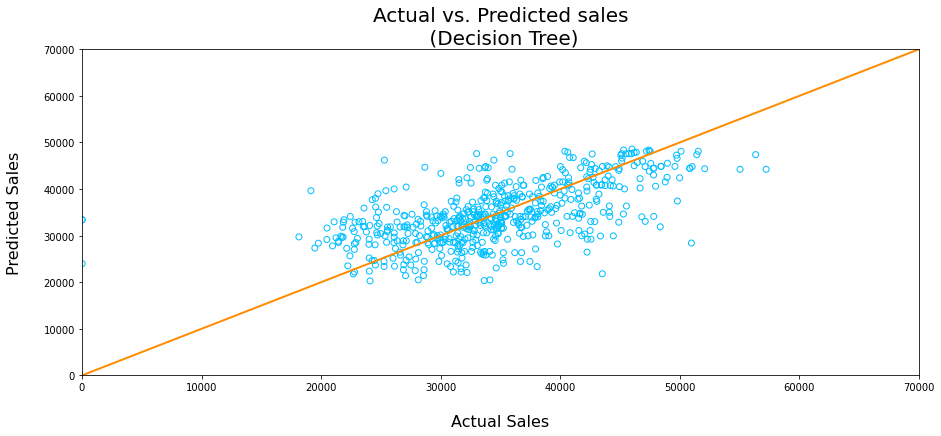

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Decision Tree)", fontsize=20)
plt.scatter(y_test, pred_dtr_noprune,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Random forest
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth' : [1, 3, 5],
              'n_estimators' : [100, 150, 200],
              'max_features' : [3, 6, 9],
              'min_samples_split' : [2, 4, 6]}
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state=42),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 5)
grid_search.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [1, 3, 5], 'max_features': [3, 6, 9],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_depth': 5,
 'max_features': 6,
 'min_samples_split': 4,
 'n_estimators': 200}

In [ ]:
regressor_rf = RandomForestRegressor(max_depth=5, n_estimators=200, max_features=6, min_samples_split=4, random_state=1)
regressor_rf_fit = regressor_rf.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

In [ ]:
rand_for_pred = regressor_rf_fit.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

In [ ]:
print('Mape:', round(mape(y_test, (rand_for_pred)), 2))
print('Rmse:', round(rmse(y_test, (rand_for_pred)), 2))
print('Mpe:', round(mpe(y_test, (rand_for_pred)), 2))

Mape: 1124.84
Rmse: 33610394.03
Mpe: -1115.37


In [ ]:
# Boosting
from sklearn.ensemble import AdaBoostRegressor
boosting = AdaBoostRegressor(n_estimators=100, random_state=2)
boosting_fit = boosting.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

In [ ]:
boost_pred = boosting_fit.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

In [ ]:
print('Mape:', round(mape(y_test, (boost_pred)), 2))
print('Rmse:', round(rmse(y_test, (boost_pred)), 2))
print('Mpe:', round(mpe(y_test, (boost_pred)), 2))

Mape: 1072.86
Rmse: 30490163.88
Mpe: -1061.48


###States

In [ ]:
X_train = train_s.drop('sales', 1)
X_test = test_s.drop('sales', 1)
y_train = train_s['sales']
y_test = test_s['sales']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
train_s

sales  revenue    year  month  wday  weekday  sextou  weekend  \
state_id d                                                                     
WI       1772  15374  44608.0  2015.0   12.0   1.0      0.0     0.0      1.0   
TX       139    6941  18912.0  2011.0    6.0   6.0      1.0     0.0      0.0   
         45     7745  20112.0  2011.0    3.0   3.0      1.0     0.0      0.0   
CA       1479  16634  53728.0  2015.0    2.0   2.0      0.0     0.0      1.0   
WI       91     6573  18000.0  2011.0    4.0   7.0      0.0     1.0      0.0   
...              ...      ...     ...    ...   ...      ...     ...      ...   
TX       1423  10749  34016.0  2014.0   12.0   2.0      0.0     0.0      1.0   
         602    9852  26352.0  2012.0    9.0   7.0      0.0     1.0      0.0   
         1694  10495  32128.0  2015.0    9.0   7.0      0.0     1.0      0.0   
WI       1879  10846  31392.0  2016.0    3.0   3.0      1.0     0.0      0.0   
TX       663   11863  30880.0  2012.0   11.0   5.0      1.0     0.0      0.0   

               event_type_1_Cultural  event_type_1_National  \
state_id d                                                    
WI       1772                    0.0                    0.0   
TX       139                     0.0                    0.0   
         45                      0.0                    0.0   
CA       1479                    0.0                    0.0   
WI       91                      0.0                    0.0   
...                              ...                    ...   
TX       1423                    0.0                    0.0   
         602                     0.0                    0.0   
         1694                    0.0                    0.0   
WI       1879                    0.0                    0.0   
TX       663                     0.0                    0.0   

               event_type_1_Religious  event_type_1_Sporting  snap_CA  \
state_id d                                                              
WI       1772                     0.0                    0.0      1.0   
TX       139                      0.0                    0.0      0.0   
         45                       0.0                    0.0      0.0   
CA       1479                     0.0                    0.0      0.0   
WI       91                       0.0                    0.0      0.0   
...                               ...                    ...      ...   
TX       1423                     0.0                    0.0      0.0   
         602                      0.0                    0.0      0.0   
         1694                     0.0                    0.0      0.0   
WI       1879                     0.0                    0.0      0.0   
TX       663                      0.0                    0.0      0.0   

               snap_WI  snap_TX  avg_price  
state_id d                                  
WI       1772      1.0      1.0   2.900526  
TX       139       0.0      0.0   2.724626  
         45        1.0      0.0   2.596956  
CA       1479      1.0      1.0   3.229594  
WI       91        0.0      0.0   2.738076  
...                ...      ...        ...  
TX       1423      0.0      0.0   3.164154  
         602       0.0      0.0   2.675002  
         1694      0.0      0.0   3.061150  
WI       1879      0.0      0.0   2.894329  
TX       663       0.0      0.0   2.602766  

[3816 rows x 16 columns]

In [ ]:
# Modelo Naive
naive_model = y_train.mean()
pred_naive = np.repeat(naive_model, len(y_test))
print('Mape:', round(mape(y_test, (pred_naive)), 2))
print('Rmse:', round(rmse(y_test, (pred_naive)), 2))
print('Mpe:', round(mpe(y_test, (pred_naive)), 2))

Mape: 1056.71
Rmse: 11459162.58
Mpe: -1035.99


In [ ]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train [['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX','event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)
pred_linear = linear_reg.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

print('Mape:', round(mape(y_test, (pred_linear)), 2))
print('Rmse:', round(rmse(y_test, (pred_linear)), 2))
print('Mpe:', round(mpe(y_test, (pred_linear)), 2))

Mape: 565.69
Rmse: 5341365.85
Mpe: -548.57


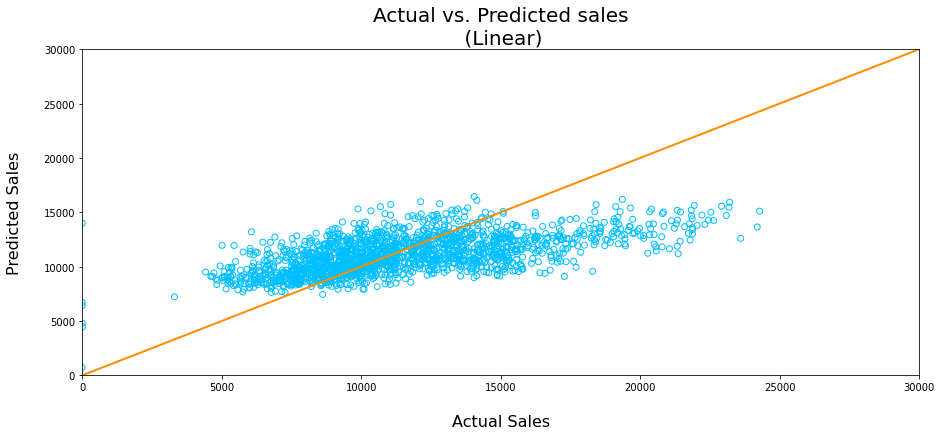

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Linear)", fontsize=20)
plt.scatter(y_test, pred_linear,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 30000], [0, 30000], "darkorange", lw=2)
plt.xlim(0, 30000)
plt.ylim(0, 30000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
linear_reg = sm.OLS(y_train, X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']] )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])
print(linear_reg_fit.summary())

print('Mape:', round(mape(y_test, (linear_reg_pred)), 2))
print('Rmse:', round(rmse(y_test, (linear_reg_pred)), 2))
print('Mpe:', round(mpe(y_test, (linear_reg_pred)), 2))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     161.9
Date:                Tue, 31 May 2022   Prob (F-statistic):          5.92e-284
Time:                        21:30:00   Log-Likelihood:                -35302.
No. Observations:                3816   AIC:                         7.063e+04
Df Residuals:                    3805   BIC:                         7.070e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
avg_price               5924

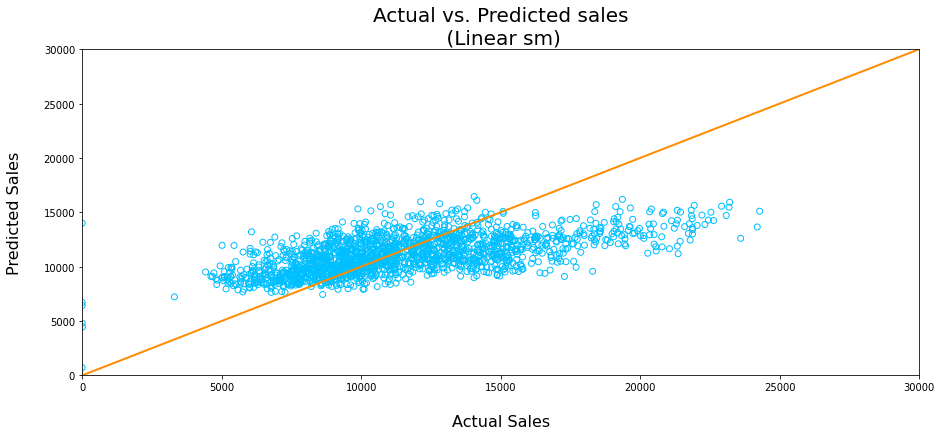

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Linear sm)", fontsize=20)
plt.scatter(y_test, linear_reg_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 30000], [0, 30000], "darkorange", lw=2)
plt.xlim(0, 30000)
plt.ylim(0, 30000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
X_lr = sm.add_constant( X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']] )

X_lr_test = sm.add_constant( X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']] )
linear_reg = sm.OLS(y_train, X_lr )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_lr_test)
print(linear_reg_fit.summary())

print('Mape:', round(mape(y_test, (linear_reg_pred)), 2))
print('Rmse:', round(rmse(y_test, (linear_reg_pred)), 2))
print('Mpe:', round(mpe(y_test, (linear_reg_pred)), 2))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     161.9
Date:                Tue, 31 May 2022   Prob (F-statistic):          5.92e-284
Time:                        21:30:01   Log-Likelihood:                -35302.
No. Observations:                3816   AIC:                         7.063e+04
Df Residuals:                    3805   BIC:                         7.070e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4314

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



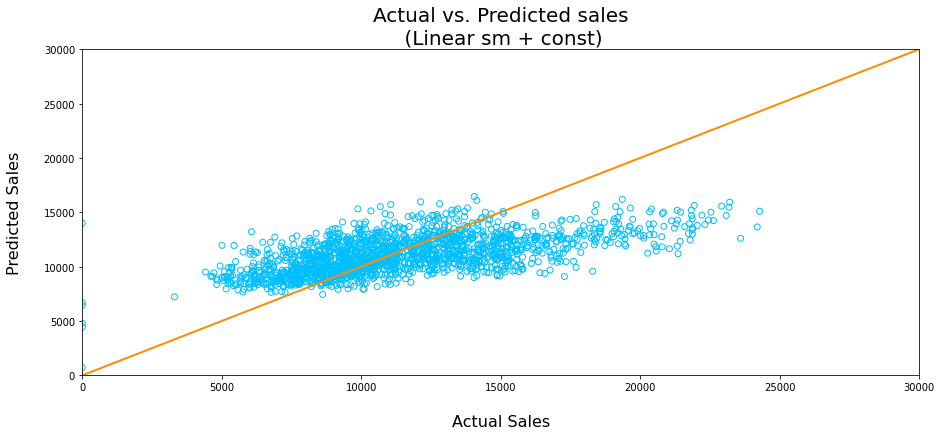

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Linear sm + const)", fontsize=20)
plt.scatter(y_test, linear_reg_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 30000], [0,30000], "darkorange", lw=2)
plt.xlim(0, 30000)
plt.ylim(0, 30000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Ridge

alphas = [0.01, 0.02, 0.03, 0.04, 0.05,
          0.1, 0.2, 0.3, 0.4, 0.5,
          0.75, 1, 2,  3, 4, 5, 
          10, 15, 30]

coefs = []
mapes = []
for a in alphas:

    # Initialize, fit & predict
    ridge_reg =  Ridge(alpha = a)
    ridge_reg.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)
    ridge_pred = ridge_reg.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

    # Save relevant info
    mapes .append(mape( y_test, (ridge_pred)))   
    coefs.append(ridge_reg.coef_)

coef_ridge = pd.DataFrame(coefs, columns= X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns)
coef_ridge.insert(0, 'Alpha', alphas)
coeg_ridge_melted = coef_ridge.melt(id_vars = 'Alpha')

cv_ridge = pd.DataFrame({ 
    'Alpha': alphas,
    'MAPE': mapes
} )

In [ ]:
cv_ridge

,Alpha,MAPE
0,0.01,565.717057
1,0.02,565.743183
2,0.03,565.769306
3,0.04,565.795426
4,0.05,565.821542
5,0.10,565.952075
6,0.20,566.212896
7,0.30,566.473391
8,0.40,566.733561
9,0.50,566.993406


In [ ]:
px.line(coeg_ridge_melted, x='Alpha', y='value', color = 'variable' )

In [ ]:
ridge_reg = Ridge(alpha = 0.01)
ridge_reg.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)
ridge_pred = ridge_reg.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

print('Mape:', round(mape(y_test, (ridge_pred)), 2))
print('Rmse:', round(rmse(y_test, (ridge_pred)), 2))
print('Mpe:', round(mpe(y_test, (ridge_pred)), 2))

Mape: 565.72
Rmse: 5341456.29
Mpe: -548.6


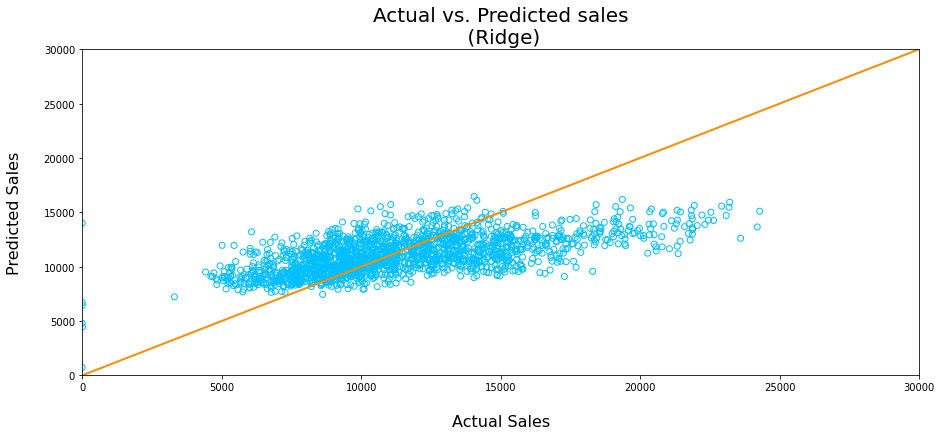

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Ridge)", fontsize=20)
plt.scatter(y_test, ridge_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 30000], [0,30000], "darkorange", lw=2)
plt.xlim(0, 30000)
plt.ylim(0, 30000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Lasso

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

lasso_pred = model_lasso.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

coef = pd.Series(model_lasso.coef_, index = X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 2 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

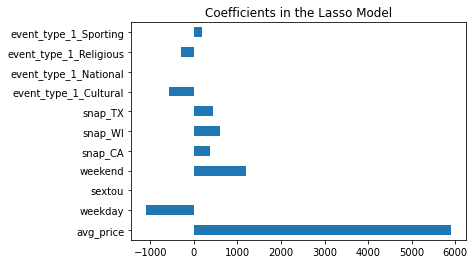

In [ ]:
coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [ ]:
print('Mape:', round(mape(y_test, (lasso_pred)), 2))
print('Rmse:', round(rmse(y_test, (lasso_pred)), 2))
print('Mpe:', round(mpe(y_test, (lasso_pred)), 2))

Mape: 571.74
Rmse: 5395903.96
Mpe: -554.63


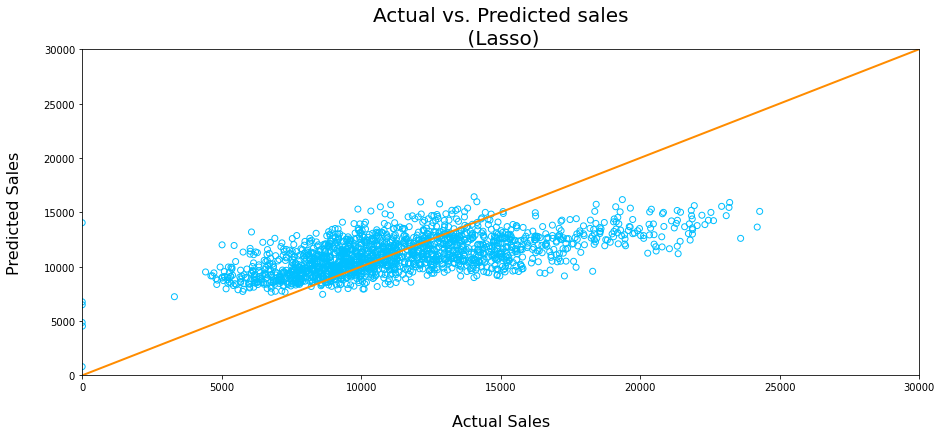

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Lasso)", fontsize=20)
plt.scatter(y_test, lasso_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 30000], [0,30000], "darkorange", lw=2)
plt.xlim(0, 30000)
plt.ylim(0, 30000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Elastic Net

model_ElasticNet = ElasticNetCV(
    l1_ratio = [.1, .5, .7, .9, .95, .99, 1],
    n_alphas = 100,
    fit_intercept = True
).fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

elastic_pred = model_ElasticNet.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

In [ ]:
coef = pd.Series(model_ElasticNet.coef_, index = X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 8 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Coefficients in the ElasticNet Model')

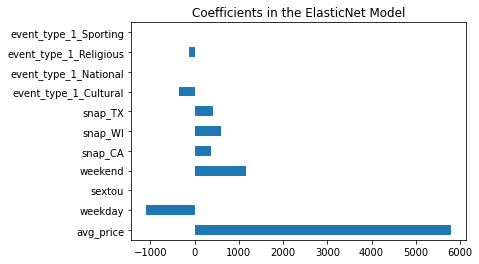

In [ ]:
coef.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")

In [ ]:
print('Mape:', round(mape(y_test, (elastic_pred)), 2))
print('Rmse:', round(rmse(y_test, (elastic_pred)), 2))
print('Mpe:', round(mpe(y_test, (elastic_pred)), 2))

Mape: 579.64
Rmse: 5418892.71
Mpe: -562.52


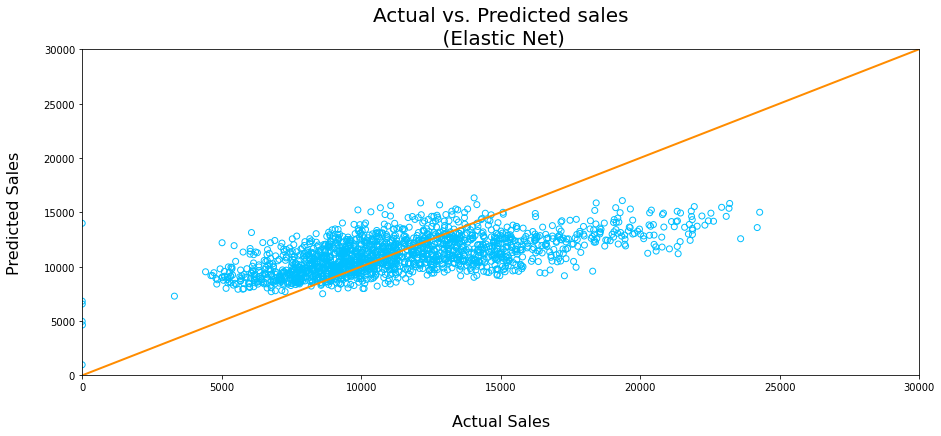

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Elastic Net)", fontsize=20)
plt.scatter(y_test, elastic_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 30000], [0,30000], "darkorange", lw=2)
plt.xlim(0, 30000)
plt.ylim(0, 30000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Decision Tree

def find_best_rule(X, y, verbo = False):
    
    best_feature, best_threshold, min_RSS = None, None, np.inf
    
    for feature in X.columns:
       #--------------------------------------------------------- #
       #  This is the "compute_RSS_by_threshold"                  #
       #----------------------------------------------------------#                                                          
        
        thresholds = X[feature].unique().tolist()           #
        thresholds.sort()                                         #
        thresholds = thresholds[1:]                               #
                                                                  #  
        for t in thresholds:                                      #
            x_index = X[feature] < t                        #
            y_left, y_right = y[x_index], y[~x_index] #
            t_RSS = RSS(y_left, y_right)                          #
        #-------------------------------------------------------- #
        
        # If you wanna gain some intuition, set verbo = True
            if verbo == True:
                print('---')
                print("Feature: ", feature)
                print("Threshold: ",t)
                print("Feature-Threshold RSS: ", t_RSS)
                print("Current minimum RSS: ", min_RSS)

        # Save the best_feature and best_threshold!        
            if t_RSS < min_RSS:
                
                min_RSS = t_RSS
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold}

In [ ]:
def squared_residual_sum(y):
    return np.sum((y - np.mean(y)) ** 2)
    
def RSS(y_left, y_right):
    return np.round(squared_residual_sum(y_left) + squared_residual_sum(y_right), 2)

In [ ]:
def DecisionTreeRegressor(X, y, depth, max_depth):
    
    print("Depth"); print(depth)

    # Stop criterias:
    if depth == max_depth or len(X) < 2:   
        print('Stop Criteria Satisfied! Reached terminal node')
        print('Prediction =', np.mean(y))
        # If we are in a leaf node, return its prediction   
        return {'prediction': np.mean(y)}     
    
    rule = find_best_rule(X, y)
    
    print("Rule")
    print(rule)  

    left_ix = X[rule['feature']] < rule['threshold']

    # Here is where the recursion kick-in (so beautiful)
    print('left <-------------')
    rule['left'] = DecisionTreeRegressor( X[left_ix], y[left_ix], 
                                          depth + 1, max_depth )
    
    print(' -------------> right ')
    rule['right'] = DecisionTreeRegressor( X[~left_ix], y[~left_ix],
                                           depth + 1, max_depth)
    
    return rule  

In [ ]:
tree = DecisionTreeRegressor(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX','event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train, 0, 3)

Depth
0
Rule
{'feature': 'avg_price', 'threshold': 2.7438323497772217}
left <-------------
Depth
1
Rule
{'feature': 'weekday', 'threshold': 1.0}
left <-------------
Depth
2
Rule
{'feature': 'snap_WI', 'threshold': 1.0}
left <-------------
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 10270.510791366907
 -------------> right 
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 11491.111587982832
 -------------> right 
Depth
2
Rule
{'feature': 'avg_price', 'threshold': 2.653630256652832}
left <-------------
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 8152.842829076621
 -------------> right 
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 9421.532731376976
 -------------> right 
Depth
1
Rule
{'feature': 'weekend', 'threshold': 1.0}
left <-------------
Depth
2
Rule
{'feature': 'avg_price', 'threshold': 3.043637752532959}
left <-------------
Depth
3
Stop Criteria Satisfied! Reached terminal node
Prediction = 1

In [ ]:
from sklearn import tree as sk_tree
from sklearn.metrics import median_absolute_error, mean_absolute_error, r2_score, explained_variance_score

In [ ]:
dtr = sk_tree.DecisionTreeRegressor(max_depth = 3).fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']],y_train)


In [ ]:
import graphviz
dtr_noprune = sk_tree.DecisionTreeRegressor().fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']],y_train)

dot_data = sk_tree.export_graphviz(dtr_noprune, out_file=None, 
                     filled=True, rounded=True,
                     feature_names = X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns) 

In [ ]:
pred_dtr = dtr.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])
pred_dtr_noprune = dtr_noprune.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])
accuracy = pd.DataFrame({'explained variance': explained_variance_score(y_test, pred_dtr),
                    'mean abs error': mean_absolute_error(y_test,pred_dtr) ,
                    'median abs error':median_absolute_error(y_test, pred_dtr),
                    'r2': r2_score(y_test,pred_dtr)},
                    index = ['Tree']
                    )

accuracy.loc['No Prune'] = [explained_variance_score(y_test, pred_dtr_noprune),
                            mean_absolute_error(y_test,pred_dtr_noprune) ,
                            median_absolute_error(y_test, pred_dtr_noprune),
                            r2_score(y_test,pred_dtr_noprune)]

accuracy

,explained variance,mean abs error,median abs error,r2
Tree,0.308532,2429.614678,1967.881262,0.297951
No Prune,-0.119735,3061.552265,2421.500000,-0.126798


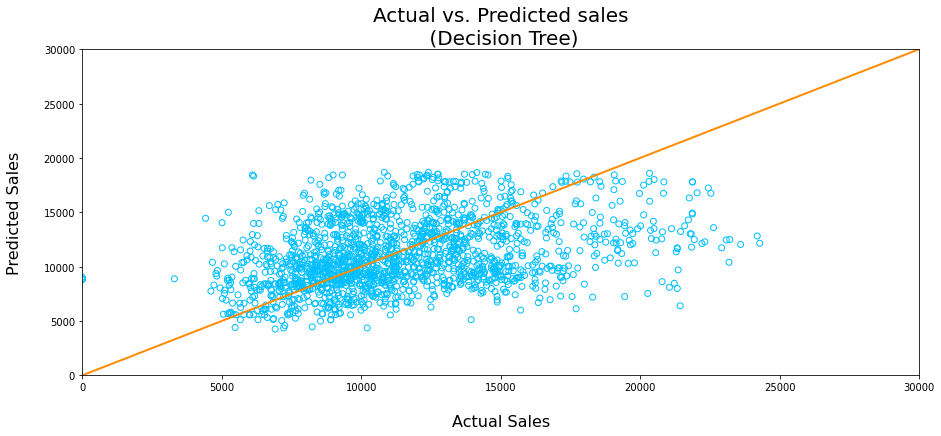

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Decision Tree)", fontsize=20)
plt.scatter(y_test, pred_dtr_noprune,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 30000], [0,30000], "darkorange", lw=2)
plt.xlim(0, 30000)
plt.ylim(0, 30000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Random forest
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth' : [1, 3, 5],
              'n_estimators' : [100, 150, 200],
              'max_features' : [3, 6, 9],
              'min_samples_split' : [2, 4, 6]}
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state=42),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 5)
grid_search.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX','event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [1, 3, 5], 'max_features': [3, 6, 9],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_depth': 5,
 'max_features': 6,
 'min_samples_split': 4,
 'n_estimators': 100}

In [ ]:
regressor_rf = RandomForestRegressor(max_depth=5, n_estimators=100, max_features=6, min_samples_split=4, random_state=1)
regressor_rf_fit = regressor_rf.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX','event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

In [ ]:
rand_for_pred = regressor_rf_fit.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX','event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

In [ ]:
print('Mape:', round(mape(y_test, (rand_for_pred)), 2))
print('Rmse:', round(rmse(y_test, (rand_for_pred)), 2))
print('Mpe:', round(mpe(y_test, (rand_for_pred)), 2))

Mape: 856.85
Rmse: 8127849.6
Mpe: -839.62


In [ ]:
# Boosting
from sklearn.ensemble import AdaBoostRegressor
boosting = AdaBoostRegressor(n_estimators=100, random_state=2)
boosting_fit = boosting.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX','event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

In [ ]:
boost_pred = boosting_fit.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap_CA', 'snap_WI', 'snap_TX','event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

In [ ]:
print('Mape:', round(mape(y_test, (boost_pred)), 2))
print('Rmse:', round(rmse(y_test, (boost_pred)), 2))
print('Mpe:', round(mpe(y_test, (boost_pred)), 2))

Mape: 901.69
Rmse: 8870712.51
Mpe: -885.93


###Categories

In [ ]:
X_train = train_c.drop('sales', 1)
X_test = test_c.drop('sales', 1)
y_train = train_c['sales']
y_test = test_c['sales']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
train_c

sales  revenue    year  month  wday  weekday  sextou  \
cat_id    d                                                              
HOUSEHOLD 1772  11871.0  47168.0  2015.0   12.0   1.0      0.0     0.0   
HOBBIES   139    2802.0   7652.0  2011.0    6.0   6.0      1.0     0.0   
          45     2500.0   6584.0  2011.0    3.0   3.0      1.0     0.0   
FOODS     1024  28723.0      inf  2013.0   11.0   2.0      0.0     0.0   
          1479  28746.0      inf  2015.0    2.0   2.0      0.0     0.0   
...                 ...      ...     ...    ...   ...      ...     ...   
HOBBIES   1423   3893.0  15720.0  2014.0   12.0   2.0      0.0     0.0   
          602    2483.0  10448.0  2012.0    9.0   7.0      0.0     1.0   
          1694   4099.0  17248.0  2015.0    9.0   7.0      0.0     1.0   
HOUSEHOLD 1879   9108.0  36512.0  2016.0    3.0   3.0      1.0     0.0   
HOBBIES   663    2195.0   9952.0  2012.0   11.0   5.0      1.0     0.0   

                weekend  event_type_1_Cultural  event_type_1_National  \
cat_id    d                                                             
HOUSEHOLD 1772      1.0                    0.0                    0.0   
HOBBIES   139       0.0                    0.0                    0.0   
          45        0.0                    0.0                    0.0   
FOODS     1024      1.0                    0.0                    0.0   
          1479      1.0                    0.0                    0.0   
...                 ...                    ...                    ...   
HOBBIES   1423      1.0                    0.0                    0.0   
          602       0.0                    0.0                    0.0   
          1694      0.0                    0.0                    0.0   
HOUSEHOLD 1879      0.0                    0.0                    0.0   
HOBBIES   663       0.0                    0.0                    0.0   

                event_type_1_Religious  event_type_1_Sporting  snap     d  
cat_id    d                                                                
HOUSEHOLD 1772                     0.0                    0.0   3.0  1772  
HOBBIES   139                      0.0                    0.0   0.0   139  
          45                       0.0                    0.0   1.0    45  
FOODS     1024                     0.0                    0.0   0.0  1024  
          1479                     0.0                    0.0   2.0  1479  
...                                ...                    ...   ...   ...  
HOBBIES   1423                     0.0                    0.0   0.0  1423  
          602                      0.0                    0.0   0.0   602  
          1694                     0.0                    0.0   0.0  1694  
HOUSEHOLD 1879                     0.0                    0.0   0.0  1879  
HOBBIES   663                      0.0                    0.0   0.0   663  

[3871 rows x 14 columns]

In [ ]:
# Modelo Naive
naive_model = y_train.mean()
pred_naive = np.repeat(naive_model, len(y_test))
print('Mape:', round(mape(y_test, (pred_naive)), 2))
print('Rmse:', round(rmse(y_test, (pred_naive)), 2))
print('Mpe:', round(mpe(y_test, (pred_naive)), 2))

Mape: inf
Rmse: inf
Mpe: -inf


In [ ]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train [['avg_price', 'weekday', 'sextou', 'weekend', 'snap','event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)
pred_linear = linear_reg.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

print('Mape:', round(mape(y_test, (pred_linear)), 2))
print('Rmse:', round(rmse(y_test, (pred_linear)), 2))
print('Mpe:', round(mpe(y_test, (pred_linear)), 2))

KeyError: ignored

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Linear)", fontsize=20)
plt.scatter(y_test, pred_linear,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0, 70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
linear_reg = sm.OLS(y_train, X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']] )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])
print(linear_reg_fit.summary())

print('Mape:', round(mape(y_test, (linear_reg_pred)), 2))
print('Rmse:', round(rmse(y_test, (linear_reg_pred)), 2))
print('Mpe:', round(mpe(y_test, (linear_reg_pred)), 2))

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Linear sm)", fontsize=20)
plt.scatter(y_test, linear_reg_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0, 70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
X_lr = sm.add_constant( X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']] )

X_lr_test = sm.add_constant( X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']] )
linear_reg = sm.OLS(y_train, X_lr )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_lr_test)
print(linear_reg_fit.summary())

print('Mape:', round(mape(y_test, (linear_reg_pred)), 2))
print('Rmse:', round(rmse(y_test, (linear_reg_pred)), 2))
print('Mpe:', round(mpe(y_test, (linear_reg_pred)), 2))

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Linear sm + const)", fontsize=20)
plt.scatter(y_test, linear_reg_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Ridge

alphas = [0.01, 0.02, 0.03, 0.04, 0.05,
          0.1, 0.2, 0.3, 0.4, 0.5,
          0.75, 1, 2,  3, 4, 5, 
          10, 15, 30]

coefs = []
mapes = []
for a in alphas:

    # Initialize, fit & predict
    ridge_reg =  Ridge(alpha = a)
    ridge_reg.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)
    ridge_pred = ridge_reg.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

    # Save relevant info
    mapes .append(mape( y_test, (ridge_pred)))   
    coefs.append(ridge_reg.coef_)

coef_ridge = pd.DataFrame(coefs, columns= X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns)
coef_ridge.insert(0, 'Alpha', alphas)
coeg_ridge_melted = coef_ridge.melt(id_vars = 'Alpha')

cv_ridge = pd.DataFrame({ 
    'Alpha': alphas,
    'MAPE': mapes
} )

In [ ]:
cv_ridge

In [ ]:
px.line(coeg_ridge_melted, x='Alpha', y='value', color = 'variable' )

In [ ]:
ridge_reg = Ridge(alpha = 0.01)
ridge_reg.fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)
ridge_pred = ridge_reg.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

print('Mape:', round(mape(y_test, (ridge_pred)), 2))
print('Rmse:', round(rmse(y_test, (ridge_pred)), 2))
print('Mpe:', round(mpe(y_test, (ridge_pred)), 2))

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Ridge)", fontsize=20)
plt.scatter(y_test, ridge_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Lasso

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

lasso_pred = model_lasso.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

coef = pd.Series(model_lasso.coef_, index = X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [ ]:
print('Mape:', round(mape(y_test, (lasso_pred)), 2))
print('Rmse:', round(rmse(y_test, (lasso_pred)), 2))
print('Mpe:', round(mpe(y_test, (lasso_pred)), 2))

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Lasso)", fontsize=20)
plt.scatter(y_test, lasso_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Elastic Net

model_ElasticNet = ElasticNetCV(
    l1_ratio = [.1, .5, .7, .9, .95, .99, 1],
    n_alphas = 100,
    fit_intercept = True
).fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train)

elastic_pred = model_ElasticNet.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])

In [ ]:
coef = pd.Series(model_ElasticNet.coef_, index = X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
coef.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")

In [ ]:
print('Mape:', round(mape(y_test, (elastic_pred)), 2))
print('Rmse:', round(rmse(y_test, (elastic_pred)), 2))
print('Mpe:', round(mpe(y_test, (elastic_pred)), 2))

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Elastic Net)", fontsize=20)
plt.scatter(y_test, elastic_pred,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

In [ ]:
# Decision Tree

def find_best_rule(X, y, verbo = False):
    
    best_feature, best_threshold, min_RSS = None, None, np.inf
    
    for feature in X.columns:
       #--------------------------------------------------------- #
       #  This is the "compute_RSS_by_threshold"                  #
       #----------------------------------------------------------#                                                          
        
        thresholds = X[feature].unique().tolist()           #
        thresholds.sort()                                         #
        thresholds = thresholds[1:]                               #
                                                                  #  
        for t in thresholds:                                      #
            x_index = X[feature] < t                        #
            y_left, y_right = y[x_index], y[~x_index] #
            t_RSS = RSS(y_left, y_right)                          #
        #-------------------------------------------------------- #
        
        # If you wanna gain some intuition, set verbo = True
            if verbo == True:
                print('---')
                print("Feature: ", feature)
                print("Threshold: ",t)
                print("Feature-Threshold RSS: ", t_RSS)
                print("Current minimum RSS: ", min_RSS)

        # Save the best_feature and best_threshold!        
            if t_RSS < min_RSS:
                
                min_RSS = t_RSS
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold}

In [ ]:
def squared_residual_sum(y):
    return np.sum((y - np.mean(y)) ** 2)
    
def RSS(y_left, y_right):
    return np.round(squared_residual_sum(y_left) + squared_residual_sum(y_right), 2)

In [ ]:
def DecisionTreeRegressor(X, y, depth, max_depth):
    
    print("Depth"); print(depth)

    # Stop criterias:
    if depth == max_depth or len(X) < 2:   
        print('Stop Criteria Satisfied! Reached terminal node')
        print('Prediction =', np.mean(y))
        # If we are in a leaf node, return its prediction   
        return {'prediction': np.mean(y)}     
    
    rule = find_best_rule(X, y)
    
    print("Rule")
    print(rule)  

    left_ix = X[rule['feature']] < rule['threshold']

    # Here is where the recursion kick-in (so beautiful)
    print('left <-------------')
    rule['left'] = DecisionTreeRegressor( X[left_ix], y[left_ix], 
                                          depth + 1, max_depth )
    
    print(' -------------> right ')
    rule['right'] = DecisionTreeRegressor( X[~left_ix], y[~left_ix],
                                           depth + 1, max_depth)
    
    return rule  

In [ ]:
tree = DecisionTreeRegressor(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']], y_train, 0, 3)

In [ ]:
from sklearn import tree as sk_tree
from sklearn.metrics import median_absolute_error, mean_absolute_error, r2_score, explained_variance_score

In [ ]:
dtr = sk_tree.DecisionTreeRegressor(max_depth = 3).fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']],y_train)


In [ ]:
import graphviz
dtr_noprune = sk_tree.DecisionTreeRegressor().fit(X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']],y_train)

dot_data = sk_tree.export_graphviz(dtr_noprune, out_file=None, 
                     filled=True, rounded=True,
                     feature_names = X_train[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']].columns) 

In [ ]:
pred_dtr = dtr.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])
pred_dtr_noprune = dtr_noprune.predict(X_test[['avg_price', 'weekday', 'sextou', 'weekend', 'snap', 'event_type_1_Cultural', 'event_type_1_National', 'event_type_1_Religious', 'event_type_1_Sporting']])
accuracy = pd.DataFrame({'explained variance': explained_variance_score(y_test, pred_dtr),
                    'mean abs error': mean_absolute_error(y_test,pred_dtr) ,
                    'median abs error':median_absolute_error(y_test, pred_dtr),
                    'r2': r2_score(y_test,pred_dtr)},
                    index = ['Tree']
                    )

accuracy.loc['No Prune'] = [explained_variance_score(y_test, pred_dtr_noprune),
                            mean_absolute_error(y_test,pred_dtr_noprune) ,
                            median_absolute_error(y_test, pred_dtr_noprune),
                            r2_score(y_test,pred_dtr_noprune)]

accuracy

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted sales\n (Decision Tree)", fontsize=20)
plt.scatter(y_test, pred_dtr_noprune,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 70000], [0,70000], "darkorange", lw=2)
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.xlabel("\nActual Sales", fontsize=16)
plt.ylabel("Predicted Sales\n", fontsize=16)
plt.show()

### Stacking Methods

trazer gradient boosting

As seen on:

#### Total


In [ ]:
y = train_t['sales'].reset_index(drop=True)
X = train_t.iloc[:len(y), :]

#### States

#### Categories